In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('./outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [4]:
def load_dataset(index):
    with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
        params = np.load(f)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
        
    with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
        res_128_50 = np.load(f)
    with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
        res_128_10= np.load(f)
    with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
        res_128_1 = np.load(f)
    return (params, res_128_50, res_128_10, res_128_1)

4867


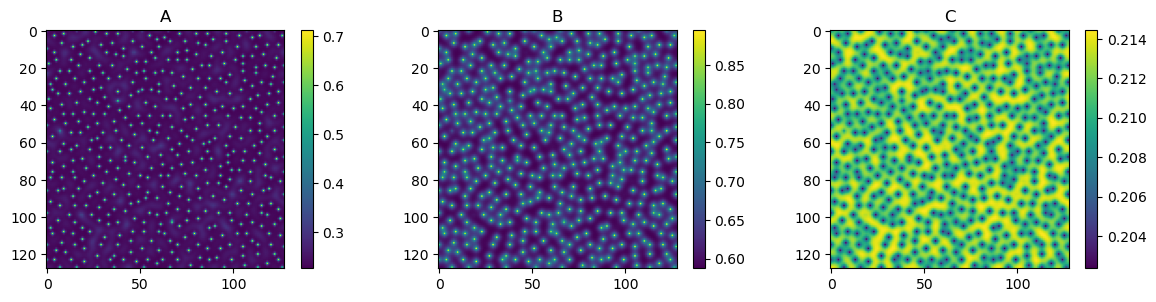

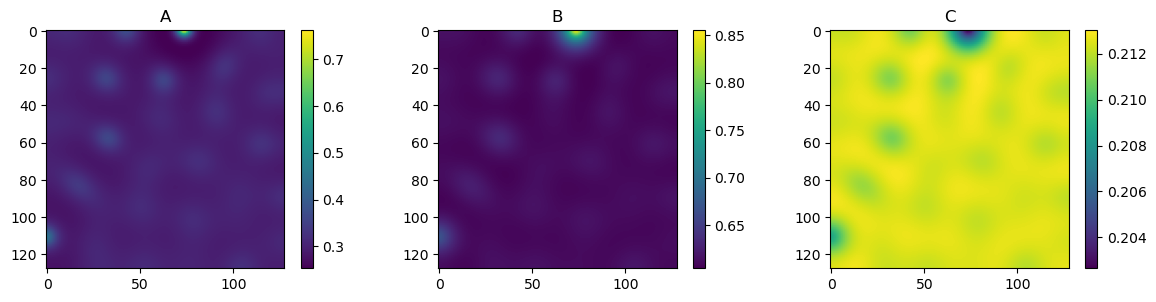

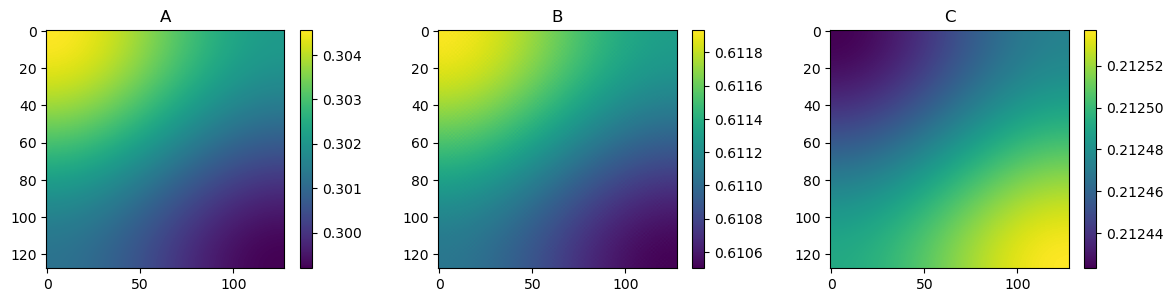

In [5]:
index = 10#2
print(indices[index])
(params, res_128_50, res_128_10, res_128_1) = load_dataset(indices[index])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res_128_50[-1, 0, :]), to(res_128_50[-1, 1, :]), to(res_128_50[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_10[-1, 0, :]), to(res_128_10[-1, 1, :]), to(res_128_10[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
plot_n_im([to(res_128_1[-1, 0, :]), to(res_128_1[-1, 1, :]), to(res_128_1[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=50
if L == 50:
    res = res_128_50
elif L == 10:
    res = res_128_10
elif L == 1:
    res = res_128_1

data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(45, 100, 1)
y_slice = slice(45, 100, 1)

x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

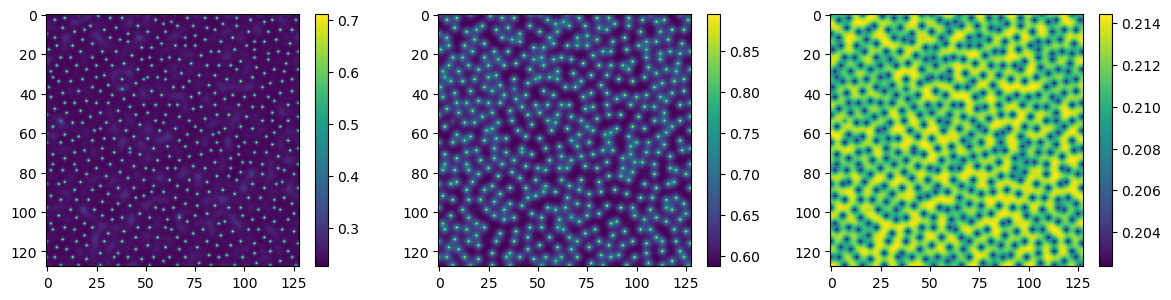

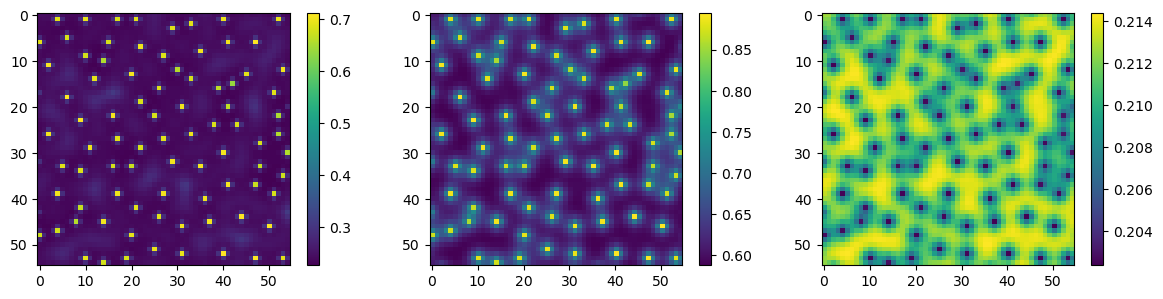

In [7]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [39]:
print(np.min(data[0, x_slice, y_slice, -1]), np.max(data[0, x_slice, y_slice, -1]))
print(np.min(data[1, x_slice, y_slice, -1]), np.max(data[1, x_slice, y_slice, -1]))
print(np.min(data[2, x_slice, y_slice, -1]), np.max(data[2, x_slice, y_slice, -1]))

0.22657609402670892 0.7120346928493714
0.5879678944135944 0.8945781714740226
0.20236859263849427 0.21440054876246586


In [8]:
c = data[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [14]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 512, 512, 3],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    V_A = create_tf_var(V_A_val)
    V_B = create_tf_var(V_B_val)
    V_C = create_tf_var(V_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    K_AA = create_tf_var(K_AA_val)
    K_AB = create_tf_var(K_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    K_CC = create_tf_var(K_CC_val)
    n = create_tf_var(n_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(V_A_val, V_A)
                    + as_tuple(V_B_val, V_B)
                    + as_tuple(V_C_val, V_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(K_AA_val, K_AA)
                    + as_tuple(K_AB_val, K_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(K_CC_val, K_CC)
                   )
    globals()["index"]=0

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
        act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
        #print(act_A_laplacian.shape)
        act_A_laplacian = flatten(act_A_laplacian)
        #print(act_A_laplacian.shape)
        act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
        act_B_laplacian = flatten(act_B_laplacian)

        act_A_rhs = tf.squeeze(D_A*act_A_laplacian/(dxdy))
        act_B_rhs = tf.squeeze(D_B*act_B_laplacian/(dxdy))
        
        def to(arr):            
            return arr.numpy().reshape(53, 53)

        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            H = H[:, 1:-1, 1:-1, :]
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])

            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            H2 = elements[1]
            # remove the boundaries
            H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                

            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs = D_A * (A_xx + A_yy)# - u_t
            B_rhs = D_B * (B_xx + B_yy)# - v_t
            

            f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
            f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
            f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
            
            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)            

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + 
                  w3*l2_res_C +
                  w4*l2_res_A_rhs + w5*l2_res_B_rhs)
        
        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, 
                l2_res_C,  
                l2_res_A_rhs, l2_res_B_rhs
        )
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5)

In [10]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.1,
 'mu_A': 0.5,
 'V_A': 20.0,
 'K_AA': 1.0,
 'K_AB': 1.0,
 'K_AC': 1.0,
 'b_B': 0.1,
 'mu_B': 0.5,
 'V_B': 25.0,
 'K_BA': 0.5,
 'K_BC': 0.5,
 'b_C': 1.0,
 'mu_C': 5.0,
 'V_C': 100.0,
 'K_CB': 100.0,
 'K_CC': 1.0}

In [15]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-4,
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 2, False),
V_A_val=tf_param("V_A", 15, False),V_B_val=tf_param("V_B", 30, False),
                                  V_C_val=tf_param("V_C", 90, False),
K_AA_val=tf_param("K_AA", 2, False),K_AB_val=tf_param("K_AB", 2, False),
K_AC_val=tf_param("K_AC", 2, False), K_BA_val=tf_param("K_BA", 1, False),
K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 90, False),
K_CC_val=tf_param("K_CC", 2, False),       
#mu_A_val=tf_param("mu_A", 1, False),mu_B_val=tf_param("mu_B", 1, False),mu_C_val=tf_param("mu_C", 1, False),
w1=1, w2=1, w3=1, w4=100, w5=100
)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 2
V_A: 15
V_B: 30
V_C: 90
mu_A: 0.5
mu_B: 0.5
mu_C: 5.0
K_AA: 2
K_AB: 2
K_AC: 2
K_BA: 1
K_BC: 1
K_CB: 90
K_CC: 2
n: 4.0


In [16]:
epochs=20000+1
params_est = np.zeros((epochs, 9))

# def epoch_callback1(epoch, loss_samples, index):
#     params_est[epoch, : ] = (b_A.numpy(), b_B.numpy(), b_C.numpy(), 
#                              V_A.numpy(), V_B.numpy(), V_C.numpy(),
#                              mu_A.numpy(), mu_B.numpy(), mu_C.numpy()
#                             )

In [17]:
losses1 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 7608.586919546127
l2_res_A: 2154.68457031, l2_res_B: 1375.05090332, l2_res_C: 2562.44384766, l2_res_A_rhs: 0.96741271, l2_res_B_rhs: 1515.44018555
b_A:0: 0.9998999834060669, b_B:0: 0.9998999834060669, b_C:0: 1.999899983406067, V_A:0: 14.999899864196777, V_B:0: 29.999900817871094, V_C:0: 89.9999008178711, K_AA:0: 2.0000998973846436, K_AB:0: 2.0000998973846436, K_AC:0: 1.999899983406067, K_BA:0: 0.9998999834060669, K_BC:0: 0.9998999834060669, K_CB:0: 90.0, K_CC:0: 2.0000998973846436
Time taken: 9.79s

Start of epoch 200
at epoch 200, total loss: 7269.868122220039
l2_res_A: 2055.58007812, l2_res_B: 1243.86950684, l2_res_C: 2454.21655273, l2_res_A_rhs: 0.96736538, l2_res_B_rhs: 1515.23461914
b_A:0: 0.9799962043762207, b_B:0: 0.9801430702209473, b_C:0: 1.9799879789352417, V_A:0: 14.980266571044922, V_B:0: 29.980300903320312, V_C:0: 89.98006439208984, K_AA:0: 2.019683837890625, K_AB:0: 2.0196588039398193, K_AC:0: 1.9800339937210083, K_BA:0: 0.9800029


Start of epoch 3000
at epoch 3000, total loss: 4039.530671477318
l2_res_A: 970.38122559, l2_res_B: 1319.19372559, l2_res_C: 1252.87683105, l2_res_A_rhs: 0.64605844, l2_res_B_rhs: 496.43283081
b_A:0: 0.7203261852264404, b_B:0: 0.7255057692527771, b_C:0: 1.7180448770523071, V_A:0: 14.77273178100586, V_B:0: 30.12425422668457, V_C:0: 89.75982666015625, K_AA:0: 2.2212600708007812, K_AB:0: 1.8720788955688477, K_AC:0: 1.7332463264465332, K_BA:0: 0.7265511751174927, K_BC:0: 0.6864144206047058, K_CB:0: 90.0, K_CC:0: 2.234226703643799
Time taken: 6.45s

Start of epoch 3200
at epoch 3200, total loss: 3861.723432660103
l2_res_A: 913.52838135, l2_res_B: 1287.21911621, l2_res_C: 1185.91284180, l2_res_A_rhs: 0.61488163, l2_res_B_rhs: 474.44821167
b_A:0: 0.7027634382247925, b_B:0: 0.7085201740264893, b_C:0: 1.7002416849136353, V_A:0: 14.761421203613281, V_B:0: 30.152101516723633, V_C:0: 89.74761962890625, K_AA:0: 2.2319979667663574, K_AB:0: 1.8433289527893066, K_AC:0: 1.7181856632232666, K_BA:0: 0.71


Start of epoch 6000
at epoch 6000, total loss: 1826.0198758244514
l2_res_A: 322.29870605, l2_res_B: 766.64135742, l2_res_C: 466.94070435, l2_res_A_rhs: 0.32117587, l2_res_B_rhs: 269.81793213
b_A:0: 0.4685575067996979, b_B:0: 0.4834011495113373, b_C:0: 1.4609605073928833, V_A:0: 14.640578269958496, V_B:0: 30.519033432006836, V_C:0: 89.62323760986328, K_AA:0: 2.3453049659729004, K_AB:0: 1.4618643522262573, K_AC:0: 1.5552334785461426, K_BA:0: 0.5127629637718201, K_BC:0: 0.423860102891922, K_CB:0: 90.0, K_CC:0: 2.3634021282196045
Time taken: 6.25s

Start of epoch 6200
at epoch 6200, total loss: 1708.5302048623562
l2_res_A: 293.49713135, l2_res_B: 724.27539062, l2_res_C: 430.10006714, l2_res_A_rhs: 0.30800638, l2_res_B_rhs: 260.34960938
b_A:0: 0.4527808129787445, b_B:0: 0.468176007270813, b_C:0: 1.444638729095459, V_A:0: 14.634519577026367, V_B:0: 30.543655395507812, V_C:0: 89.61713409423828, K_AA:0: 2.3509204387664795, K_AB:0: 1.4361371994018555, K_AC:0: 1.5469372272491455, K_BA:0: 0.5013


Start of epoch 9000
at epoch 9000, total loss: 507.0546089708805
l2_res_A: 49.35183716, l2_res_B: 200.67652893, l2_res_C: 90.15649414, l2_res_A_rhs: 0.19697347, l2_res_B_rhs: 166.67277527
b_A:0: 0.25424689054489136, b_B:0: 0.26158738136291504, b_C:0: 1.2329096794128418, V_A:0: 14.583383560180664, V_B:0: 30.818119049072266, V_C:0: 89.56532287597656, K_AA:0: 2.397984743118286, K_AB:0: 1.1485071182250977, K_AC:0: 1.4652494192123413, K_BA:0: 0.39745840430259705, K_BC:0: 0.2805497646331787, K_CB:0: 90.0, K_CC:0: 2.41610050201416
Time taken: 6.22s

Start of epoch 9200
at epoch 9200, total loss: 464.0773041844368
l2_res_A: 41.65917206, l2_res_B: 183.13800049, l2_res_C: 77.15542603, l2_res_A_rhs: 0.19100505, l2_res_B_rhs: 161.93370056
b_A:0: 0.24237191677093506, b_B:0: 0.24770291149616241, b_C:0: 1.2194714546203613, V_A:0: 14.582331657409668, V_B:0: 30.828399658203125, V_C:0: 89.56379699707031, K_AA:0: 2.3989593982696533, K_AB:0: 1.1377724409103394, K_AC:0: 1.4614055156707764, K_BA:0: 0.39563


Start of epoch 12000
at epoch 12000, total loss: 208.06348411738873
l2_res_A: 6.79630995, l2_res_B: 96.02004242, l2_res_C: 2.16967034, l2_res_A_rhs: 0.13665788, l2_res_B_rhs: 102.94080353
b_A:0: 0.1375720500946045, b_B:0: 0.12799488008022308, b_C:0: 1.0791021585464478, V_A:0: 14.758247375488281, V_B:0: 30.8764591217041, V_C:0: 89.5474624633789, K_AA:0: 2.228557586669922, K_AB:0: 1.0889464616775513, K_AC:0: 1.4275660514831543, K_BA:0: 0.6368237733840942, K_BC:0: 0.22007906436920166, K_CB:0: 90.0, K_CC:0: 2.433297872543335
Time taken: 6.45s

Start of epoch 12200
at epoch 12200, total loss: 200.9294548034668
l2_res_A: 6.42641497, l2_res_B: 93.20160675, l2_res_C: 1.51618826, l2_res_A_rhs: 0.13386238, l2_res_B_rhs: 99.65138245
b_A:0: 0.13502269983291626, b_B:0: 0.1254485845565796, b_C:0: 1.0738461017608643, V_A:0: 14.793868064880371, V_B:0: 30.877431869506836, V_C:0: 89.5474624633789, K_AA:0: 2.1922223567962646, K_AB:0: 1.0878957509994507, K_AC:0: 1.4263372421264648, K_BA:0: 0.668568372726


Start of epoch 15000
at epoch 15000, total loss: 129.53948697447777
l2_res_A: 1.27547908, l2_res_B: 62.49008179, l2_res_C: 0.45051098, l2_res_A_rhs: 0.10617575, l2_res_B_rhs: 65.21723938
b_A:0: 0.12108856439590454, b_B:0: 0.11492571979761124, b_C:0: 1.054402232170105, V_A:0: 15.188189506530762, V_B:0: 30.882261276245117, V_C:0: 89.5474624633789, K_AA:0: 1.7845685482025146, K_AB:0: 1.0794717073440552, K_AC:0: 1.4128574132919312, K_BA:0: 0.9925622344017029, K_BC:0: 0.2207876294851303, K_CB:0: 90.0, K_CC:0: 2.433100700378418
Time taken: 6.39s

Start of epoch 15200
at epoch 15200, total loss: 125.30354350805283
l2_res_A: 1.01764977, l2_res_B: 60.54293823, l2_res_C: 0.45047802, l2_res_A_rhs: 0.10462272, l2_res_B_rhs: 63.18785477
b_A:0: 0.12031500786542892, b_B:0: 0.1145506501197815, b_C:0: 1.0543996095657349, V_A:0: 15.208481788635254, V_B:0: 30.88222885131836, V_C:0: 89.5474624633789, K_AA:0: 1.7632994651794434, K_AB:0: 1.0790541172027588, K_AC:0: 1.4112868309020996, K_BA:0: 1.00800609588


Start of epoch 18000
at epoch 18000, total loss: 83.39265061169863
l2_res_A: 0.14493783, l2_res_B: 40.81605911, l2_res_C: 0.44846967, l2_res_A_rhs: 0.08833613, l2_res_B_rhs: 41.89484787
b_A:0: 0.11459115892648697, b_B:0: 0.11091508716344833, b_C:0: 1.0542867183685303, V_A:0: 15.327659606933594, V_B:0: 30.87417984008789, V_C:0: 89.56380462646484, K_AA:0: 1.636655569076538, K_AB:0: 1.0744024515151978, K_AC:0: 1.325623631477356, K_BA:0: 1.0912948846817017, K_BC:0: 0.2757164239883423, K_CB:0: 90.0, K_CC:0: 2.4165611267089844
Time taken: 6.42s

Start of epoch 18200
at epoch 18200, total loss: 81.95898505300283
l2_res_A: 0.14471975, l2_res_B: 40.11308670, l2_res_C: 0.44794476, l2_res_A_rhs: 0.08812612, l2_res_B_rhs: 41.16510773
b_A:0: 0.11456948518753052, b_B:0: 0.11072231829166412, b_C:0: 1.0542628765106201, V_A:0: 15.328081130981445, V_B:0: 30.872844696044922, V_C:0: 89.5678939819336, K_AA:0: 1.636118769645691, K_AB:0: 1.0741640329360962, K_AC:0: 1.3058676719665527, K_BA:0: 1.091021299362

In [54]:
print(params)

{'D_A': 0.01, 'D_B': 1.0, 'n': 4.0, 'b_A': 0.1, 'mu_A': 0.5, 'V_A': 20.0, 'K_AA': 1.0, 'K_AB': 1.0, 'K_AC': 1.0, 'b_B': 0.1, 'mu_B': 0.5, 'V_B': 25.0, 'K_BA': 0.5, 'K_BC': 0.5, 'b_C': 1.0, 'mu_C': 5.0, 'V_C': 100.0, 'K_CB': 100.0, 'K_CC': 1.0}


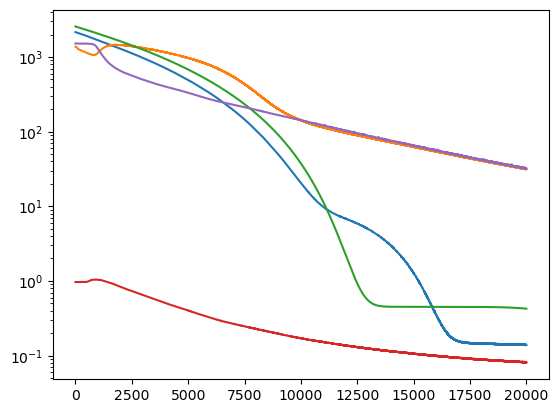

In [18]:
plt.plot(losses1)
plt.yscale('log')

In [19]:
losses2 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 64.33118852972984
l2_res_A: 0.13914898, l2_res_B: 31.51366043, l2_res_C: 0.42582378, l2_res_A_rhs: 0.08185527, l2_res_B_rhs: 32.17070007
b_A:0: 0.11445702612400055, b_B:0: 0.10925561934709549, b_C:0: 1.0529519319534302, V_A:0: 15.331533432006836, V_B:0: 30.856727600097656, V_C:0: 89.71630096435547, K_AA:0: 1.6316869258880615, K_AB:0: 1.0721784830093384, K_AC:0: 0.9617382287979126, K_BA:0: 1.0842818021774292, K_BC:0: 0.47003522515296936, K_CB:0: 90.0, K_CC:0: 2.2683610916137695
Time taken: 0.14s

Start of epoch 200
at epoch 200, total loss: 62.187259040772915
l2_res_A: 0.13793585, l2_res_B: 30.46738434, l2_res_C: 0.42054915, l2_res_A_rhs: 0.08055436, l2_res_B_rhs: 31.08083534
b_A:0: 0.11444785445928574, b_B:0: 0.10909802466630936, b_C:0: 1.0525890588760376, V_A:0: 15.332043647766113, V_B:0: 30.854595184326172, V_C:0: 89.74834442138672, K_AA:0: 1.6310006380081177, K_AB:0: 1.0719757080078125, K_AC:0: 0.9174681901931763, K_BA:0: 1.0830072164535522,


Start of epoch 3200
at epoch 3200, total loss: 42.348410457372665
l2_res_A: 0.12978023, l2_res_B: 20.80589104, l2_res_C: 0.32535526, l2_res_A_rhs: 0.07311696, l2_res_B_rhs: 21.01426697
b_A:0: 0.11408832669258118, b_B:0: 0.10740318894386292, b_C:0: 1.043789267539978, V_A:0: 15.350390434265137, V_B:0: 30.823741912841797, V_C:0: 90.17432403564453, K_AA:0: 1.6049741506576538, K_AB:0: 1.0695654153823853, K_AC:0: 0.5226986408233643, K_BA:0: 1.034185528755188, K_BC:0: 0.7596039772033691, K_CB:0: 90.0, K_CC:0: 1.7973977327346802
Time taken: 6.34s

Start of epoch 3400
at epoch 3400, total loss: 41.74314118921757
l2_res_A: 0.12881099, l2_res_B: 20.49001884, l2_res_C: 0.31791362, l2_res_A_rhs: 0.07263881, l2_res_B_rhs: 20.73375893
b_A:0: 0.11403802782297134, b_B:0: 0.10732914507389069, b_C:0: 1.0429439544677734, V_A:0: 15.353095054626465, V_B:0: 30.82172203063965, V_C:0: 90.19873809814453, K_AA:0: 1.6011780500411987, K_AB:0: 1.0694230794906616, K_AC:0: 0.5192723274230957, K_BA:0: 1.0274920463562


Start of epoch 6400
at epoch 6400, total loss: 28.689304634928703
l2_res_A: 0.10500196, l2_res_B: 14.13626194, l2_res_C: 0.16028960, l2_res_A_rhs: 0.06832594, l2_res_B_rhs: 14.21942520
b_A:0: 0.11175261437892914, b_B:0: 0.10628202557563782, b_C:0: 1.0231128931045532, V_A:0: 15.46790599822998, V_B:0: 30.792083740234375, V_C:0: 90.55424499511719, K_AA:0: 1.4488210678100586, K_AB:0: 1.0678739547729492, K_AC:0: 0.5379509329795837, K_BA:0: 0.8318712711334229, K_BC:0: 0.7989715933799744, K_CB:0: 90.0, K_CC:0: 1.3979880809783936
Time taken: 6.21s

Start of epoch 6600
at epoch 6600, total loss: 28.842400059103966
l2_res_A: 0.10225127, l2_res_B: 14.19197845, l2_res_C: 0.14671358, l2_res_A_rhs: 0.06799880, l2_res_B_rhs: 14.33345795
b_A:0: 0.11143944412469864, b_B:0: 0.10623335093259811, b_C:0: 1.0212064981460571, V_A:0: 15.482831001281738, V_B:0: 30.79012680053711, V_C:0: 90.57618713378906, K_AA:0: 1.4303233623504639, K_AB:0: 1.0677562952041626, K_AC:0: 0.5453961491584778, K_BA:0: 0.81421482563


Start of epoch 9600
at epoch 9600, total loss: 21.97290468774736
l2_res_A: 0.06992804, l2_res_B: 10.90721035, l2_res_C: 0.00685514, l2_res_A_rhs: 0.06607389, l2_res_B_rhs: 10.92283726
b_A:0: 0.10523022711277008, b_B:0: 0.10585647076368332, b_C:0: 0.9904436469078064, V_A:0: 15.722566604614258, V_B:0: 30.7615966796875, V_C:0: 90.82684326171875, K_AA:0: 1.134832501411438, K_AB:0: 1.0667861700057983, K_AC:0: 0.9602115750312805, K_BA:0: 0.6040627956390381, K_BC:0: 0.6602102518081665, K_CB:0: 90.0, K_CC:0: 1.104098916053772
Time taken: 6.52s

Start of epoch 9800
at epoch 9800, total loss: 20.949116348754615
l2_res_A: 0.06873304, l2_res_B: 10.39842033, l2_res_C: 0.00521897, l2_res_A_rhs: 0.06601746, l2_res_B_rhs: 10.41072655
b_A:0: 0.10481325536966324, b_B:0: 0.10574750602245331, b_C:0: 0.990413248538971, V_A:0: 15.733086585998535, V_B:0: 30.75969886779785, V_C:0: 90.83447265625, K_AA:0: 1.1183892488479614, K_AB:0: 1.0667235851287842, K_AC:0: 0.9832189083099365, K_BA:0: 0.5948653817176819, K


Start of epoch 12800
at epoch 12800, total loss: 17.28268525173189
l2_res_A: 0.06197014, l2_res_B: 8.55991554, l2_res_C: 0.00018064, l2_res_A_rhs: 0.06426062, l2_res_B_rhs: 8.59635830
b_A:0: 0.10094226896762848, b_B:0: 0.10542736202478409, b_C:0: 0.9954499006271362, V_A:0: 15.650067329406738, V_B:0: 30.73285484313965, V_C:0: 90.89552307128906, K_AA:0: 0.9875213503837585, K_AB:0: 1.0660226345062256, K_AC:0: 1.1555557250976562, K_BA:0: 0.5289938449859619, K_BC:0: 0.5548990368843079, K_CB:0: 90.0, K_CC:0: 1.0267397165298462
Time taken: 6.50s

Start of epoch 13000
at epoch 13000, total loss: 16.821519690653076
l2_res_A: 0.06242212, l2_res_B: 8.36030674, l2_res_C: 0.00014219, l2_res_A_rhs: 0.06471957, l2_res_B_rhs: 8.33392906
b_A:0: 0.10089171677827835, b_B:0: 0.10536672919988632, b_C:0: 0.9956668019294739, V_A:0: 15.633352279663086, V_B:0: 30.731103897094727, V_C:0: 90.8980712890625, K_AA:0: 0.9859079122543335, K_AB:0: 1.065949559211731, K_AC:0: 1.16170334815979, K_BA:0: 0.528397977352142


Start of epoch 16000
at epoch 16000, total loss: 13.199350344559207
l2_res_A: 0.06151127, l2_res_B: 6.54525137, l2_res_C: 0.00001042, l2_res_A_rhs: 0.06394703, l2_res_B_rhs: 6.52863026
b_A:0: 0.10075582563877106, b_B:0: 0.10518588870763779, b_C:0: 0.9973587989807129, V_A:0: 15.39001750946045, V_B:0: 30.70493507385254, V_C:0: 90.91490173339844, K_AA:0: 0.9797383546829224, K_AB:0: 1.0653893947601318, K_AC:0: 1.2002134323120117, K_BA:0: 0.5278226137161255, K_BC:0: 0.5277464985847473, K_CB:0: 90.0, K_CC:0: 1.0023524761199951
Time taken: 6.58s

Start of epoch 16200
at epoch 16200, total loss: 13.011553237747648
l2_res_A: 0.06094650, l2_res_B: 6.45572090, l2_res_C: 0.00001025, l2_res_A_rhs: 0.06339184, l2_res_B_rhs: 6.43148375
b_A:0: 0.10075902193784714, b_B:0: 0.10514095425605774, b_C:0: 0.9973994493484497, V_A:0: 15.374102592468262, V_B:0: 30.703174591064453, V_C:0: 90.91502380371094, K_AA:0: 0.9795721173286438, K_AB:0: 1.0653305053710938, K_AC:0: 1.1991944313049316, K_BA:0: 0.52789837121


Start of epoch 19200
at epoch 19200, total loss: 10.818015713964087
l2_res_A: 0.06037244, l2_res_B: 5.34993172, l2_res_C: 0.00000626, l2_res_A_rhs: 0.06295489, l2_res_B_rhs: 5.34475040
b_A:0: 0.1007348820567131, b_B:0: 0.10498170554637909, b_C:0: 0.9979705810546875, V_A:0: 15.135283470153809, V_B:0: 30.676692962646484, V_C:0: 90.91668701171875, K_AA:0: 0.9766309261322021, K_AB:0: 1.064848780632019, K_AC:0: 1.1463663578033447, K_BA:0: 0.5288428664207458, K_BC:0: 0.5214899182319641, K_CB:0: 90.0, K_CC:0: 0.9968894720077515
Time taken: 6.59s

Start of epoch 19400
at epoch 19400, total loss: 10.982983602303648
l2_res_A: 0.06008659, l2_res_B: 5.43430376, l2_res_C: 0.00000592, l2_res_A_rhs: 0.06269069, l2_res_B_rhs: 5.42589664
b_A:0: 0.10072259604930878, b_B:0: 0.1049271821975708, b_C:0: 0.9980278015136719, V_A:0: 15.119132041931152, V_B:0: 30.674915313720703, V_C:0: 90.9169921875, K_AA:0: 0.9763913154602051, K_AB:0: 1.0648126602172852, K_AC:0: 1.1412020921707153, K_BA:0: 0.5288881659507751

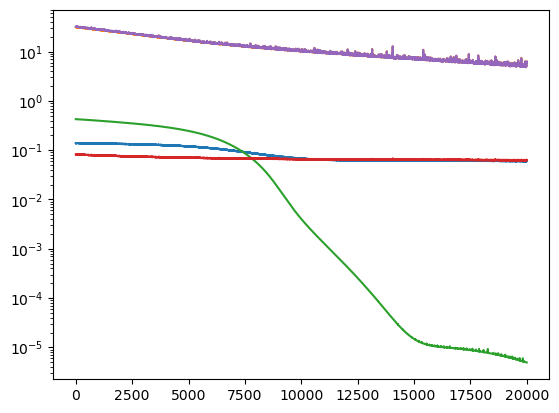

In [20]:
plt.plot(losses2)
plt.yscale('log')

In [21]:
losses3 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 11.520760549549777
l2_res_A: 0.06074135, l2_res_B: 5.71636534, l2_res_C: 0.00000493, l2_res_A_rhs: 0.06336633, l2_res_B_rhs: 5.68028259
b_A:0: 0.1007266491651535, b_B:0: 0.10493575036525726, b_C:0: 0.9981976747512817, V_A:0: 15.070845603942871, V_B:0: 30.669641494750977, V_C:0: 90.9177017211914, K_AA:0: 0.975679337978363, K_AB:0: 1.064709186553955, K_AC:0: 1.1255937814712524, K_BA:0: 0.5290274024009705, K_BC:0: 0.5192503929138184, K_CB:0: 90.0, K_CC:0: 0.9949166178703308
Time taken: 0.14s

Start of epoch 500
at epoch 500, total loss: 10.393223382423002
l2_res_A: 0.05938232, l2_res_B: 5.13797140, l2_res_C: 0.00000418, l2_res_A_rhs: 0.06200156, l2_res_B_rhs: 5.13386393
b_A:0: 0.10072828829288483, b_B:0: 0.10492048412561417, b_C:0: 0.9983440637588501, V_A:0: 15.031341552734375, V_B:0: 30.665393829345703, V_C:0: 90.91825103759766, K_AA:0: 0.9751607775688171, K_AB:0: 1.0646454095840454, K_AC:0: 1.1131141185760498, K_BA:0: 0.5291687846183777, K_BC:0:


Start of epoch 8000
at epoch 8000, total loss: 6.86143597556989
l2_res_A: 0.05734071, l2_res_B: 3.37643290, l2_res_C: 0.00000025, l2_res_A_rhs: 0.06028007, l2_res_B_rhs: 3.36738205
b_A:0: 0.10056433081626892, b_B:0: 0.10457278043031693, b_C:0: 0.9996207356452942, V_A:0: 14.435981750488281, V_B:0: 30.60240364074707, V_C:0: 90.92560577392578, K_AA:0: 0.9657641053199768, K_AB:0: 1.0635790824890137, K_AC:0: 1.0230175256729126, K_BA:0: 0.5307496786117554, K_BC:0: 0.504219114780426, K_CB:0: 90.0, K_CC:0: 0.9807040691375732
Time taken: 16.67s

Start of epoch 8500
at epoch 8500, total loss: 6.4626394001736
l2_res_A: 0.05746241, l2_res_B: 3.19396663, l2_res_C: 0.00000047, l2_res_A_rhs: 0.06041921, l2_res_B_rhs: 3.15079069
b_A:0: 0.10052020847797394, b_B:0: 0.10458385944366455, b_C:0: 0.9996610879898071, V_A:0: 14.395892143249512, V_B:0: 30.59817123413086, V_C:0: 90.92585754394531, K_AA:0: 0.9650143384933472, K_AB:0: 1.0635502338409424, K_AC:0: 1.0209020376205444, K_BA:0: 0.5308167338371277, K_


Start of epoch 16000
at epoch 16000, total loss: 3.9733446609683654
l2_res_A: 0.05579011, l2_res_B: 1.93407476, l2_res_C: 0.00000010, l2_res_A_rhs: 0.05906327, l2_res_B_rhs: 1.92441642
b_A:0: 0.10045083612203598, b_B:0: 0.10434189438819885, b_C:0: 0.9999096393585205, V_A:0: 13.793281555175781, V_B:0: 30.538183212280273, V_C:0: 90.92765808105469, K_AA:0: 0.9560392498970032, K_AB:0: 1.0627189874649048, K_AC:0: 1.005469560623169, K_BA:0: 0.5328793525695801, K_BC:0: 0.501022458076477, K_CB:0: 90.0, K_CC:0: 0.9774835705757141
Time taken: 16.37s

Start of epoch 16500
at epoch 16500, total loss: 4.6633379322544215
l2_res_A: 0.05648557, l2_res_B: 2.28685665, l2_res_C: 0.00000026, l2_res_A_rhs: 0.05978756, l2_res_B_rhs: 2.26020789
b_A:0: 0.10044598579406738, b_B:0: 0.10428939759731293, b_C:0: 0.9999080896377563, V_A:0: 13.753113746643066, V_B:0: 30.534452438354492, V_C:0: 90.92768859863281, K_AA:0: 0.9555211067199707, K_AB:0: 1.0626674890518188, K_AC:0: 1.0050311088562012, K_BA:0: 0.5330718159

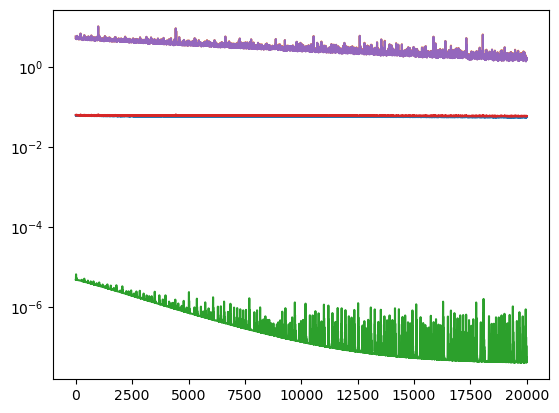

In [22]:
plt.plot(losses3)
plt.yscale('log')

In [23]:
losses4 = tu.train(epochs=epochs,
                  batch_size=55*55,#1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 3.162260398979342
l2_res_A: 0.05563565, l2_res_B: 1.53857362, l2_res_C: 0.00000005, l2_res_A_rhs: 0.05915174, l2_res_B_rhs: 1.50889933
b_A:0: 0.10042808204889297, b_B:0: 0.10425630211830139, b_C:0: 0.9999485611915588, V_A:0: 13.468610763549805, V_B:0: 30.50739860534668, V_C:0: 90.9277572631836, K_AA:0: 0.9516772627830505, K_AB:0: 1.0623195171356201, K_AC:0: 1.0029280185699463, K_BA:0: 0.534358024597168, K_BC:0: 0.5005422234535217, K_CB:0: 90.0, K_CC:0: 0.9770013093948364
Time taken: 0.15s

Start of epoch 500
at epoch 500, total loss: 4.389092808174212
l2_res_A: 0.05640989, l2_res_B: 2.15569353, l2_res_C: 0.00000005, l2_res_A_rhs: 0.05999329, l2_res_B_rhs: 2.11699605
b_A:0: 0.10042436420917511, b_B:0: 0.10431864112615585, b_C:0: 0.9999521970748901, V_A:0: 13.427643775939941, V_B:0: 30.50354766845703, V_C:0: 90.92779541015625, K_AA:0: 0.9510681629180908, K_AB:0: 1.0623338222503662, K_AC:0: 1.0027284622192383, K_BA:0: 0.5345198512077332, K_BC:0: 0


Start of epoch 8000
at epoch 8000, total loss: 2.9755439860147135
l2_res_A: 0.05465484, l2_res_B: 1.43668699, l2_res_C: 0.00000004, l2_res_A_rhs: 0.05856487, l2_res_B_rhs: 1.42563725
b_A:0: 0.10032666474580765, b_B:0: 0.10415910184383392, b_C:0: 0.9999794960021973, V_A:0: 12.8185396194458, V_B:0: 30.449779510498047, V_C:0: 90.92792510986328, K_AA:0: 0.9419170022010803, K_AB:0: 1.061650037765503, K_AC:0: 1.0011488199234009, K_BA:0: 0.5370528101921082, K_BC:0: 0.5002063512802124, K_CB:0: 90.0, K_CC:0: 0.9766563773155212
Time taken: 16.22s

Start of epoch 8500
at epoch 8500, total loss: 2.5592236918694766
l2_res_A: 0.05461457, l2_res_B: 1.23556578, l2_res_C: 0.00000004, l2_res_A_rhs: 0.05859479, l2_res_B_rhs: 1.21044850
b_A:0: 0.10031284391880035, b_B:0: 0.10418335348367691, b_C:0: 0.9999791383743286, V_A:0: 12.778374671936035, V_B:0: 30.446346282958984, V_C:0: 90.92789459228516, K_AA:0: 0.9412328600883484, K_AB:0: 1.0616341829299927, K_AC:0: 1.001102328300476, K_BA:0: 0.5372100472450256


Start of epoch 16000
at epoch 16000, total loss: 2.192899572560023
l2_res_A: 0.05406445, l2_res_B: 1.05008614, l2_res_C: 0.00000004, l2_res_A_rhs: 0.05841602, l2_res_B_rhs: 1.03033292
b_A:0: 0.10010653734207153, b_B:0: 0.10411791503429413, b_C:0: 0.9999856352806091, V_A:0: 12.162042617797852, V_B:0: 30.395750045776367, V_C:0: 90.92787170410156, K_AA:0: 0.9301728010177612, K_AB:0: 1.061031699180603, K_AC:0: 1.0007479190826416, K_BA:0: 0.5392831563949585, K_BC:0: 0.5001299381256104, K_CB:0: 90.0, K_CC:0: 0.9765791893005371
Time taken: 16.26s

Start of epoch 16500
at epoch 16500, total loss: 3.4705622604260498
l2_res_A: 0.05405688, l2_res_B: 1.69912112, l2_res_C: 0.00000022, l2_res_A_rhs: 0.05846209, l2_res_B_rhs: 1.65892196
b_A:0: 0.10008620470762253, b_B:0: 0.10409104079008102, b_C:0: 0.9999920725822449, V_A:0: 12.12027359008789, V_B:0: 30.392295837402344, V_C:0: 90.92789459228516, K_AA:0: 0.9294186234474182, K_AB:0: 1.0610132217407227, K_AC:0: 1.000741958618164, K_BA:0: 0.539435029029

In [ ]:
'b_A': 0.1, 'b_B': 0.1, 'b_C': 1.0 
'V_A': 20.0, 'V_B': 25.0, 'V_C': 100.0
'K_AA': 1.0, 
'K_AB': 1.0, 
'K_AC': 1.0,         
'K_BA': 0.5, 
'K_BC': 0.5, 
'K_CB': 100.0, 
'K_CC': 1.0

In [55]:
(b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = params_trainable1

In [60]:
(n_val, D_A_val, D_B_val,
 b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
 K_CB_val, K_CC_val ) = (params["n"], params["D_A"], params["D_B"],
                         b_A_val, b_B_val, b_C_val,
                         V_A_val, V_B_val, V_C_val,
                         params["mu_A"], params["mu_B"], params["mu_C"],
                         K_AA_val, K_AB_val, K_AC_val, 
                         K_BA_val, K_BC_val, 
                         K_CB_val, K_CC_val)

In [61]:
with open(f"./parameters_temp.npy", "wb") as f:
    np.save(f, (n_val, D_A_val, D_B_val,
                b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
                K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
                K_CB_val, K_CC_val))

In [24]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = params["D_A"]
D_B = params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [37]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        #Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            #tf.squeeze(Cg)
           )                               



def plot_state(pinn):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     #C, 
    ) = grads(pinn, H)

    A_der = D_A*( to(A_xx) + to(A_yy))
    B_der = D_B*( to(B_xx) + to(B_yy))

    actual_A_der = D_A*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = D_B*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    #A_der = A_der
    #B_der = B_der

    plot_n_im([to(A), c[0,:, : , -1], to(B), c[1,:, :  , -1]], 
      ["A", "Actual A", "B", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()

    A = c[0,:, : , -1]
    B = c[1,:, : , -1]
    print(np.sum((A_der[1:-1,1:-1]-actual_A_der[1:-1,1:-1])**2))
    print(np.sum((B_der[1:-1,1:-1]-actual_B_der[1:-1,1:-1])**2))


    plot_n_im([to(A_xx)[1:-1,1:-1], c_xx[0,x_slice, y_slice , -1],
               to(A_yy)[1:-1,1:-1], c_yy[0,x_slice, y_slice  , -1]], 
      ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(B_xx)[1:-1,1:-1], c_xx[1,x_slice, y_slice  , -1], 
               to(B_yy)[1:-1,1:-1], c_yy[1,x_slice, y_slice  , -1]],
              ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
   # plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
    #           ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
    #           figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
    plot_n_im([A_der[1:-1,1:-1],  actual_A_der[1:-1,1:-1]],
              ["RHS A", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der[1:-1,1:-1],  actual_B_der[1:-1,1:-1]],
              ["RHS B", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()

0.05824955831719255
0.8170887512396328


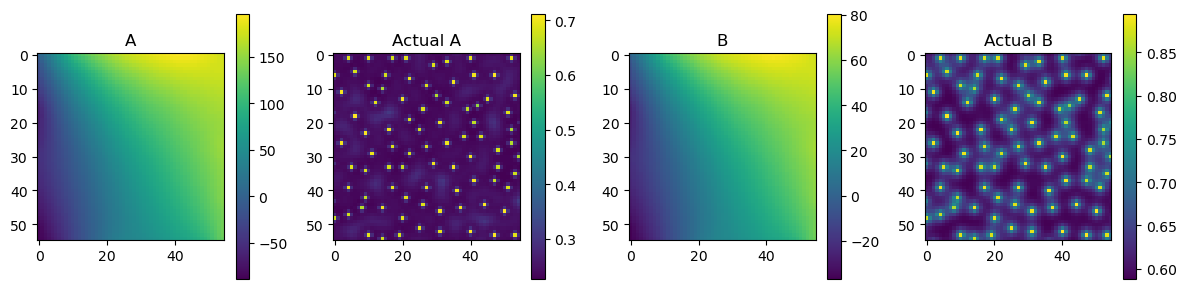

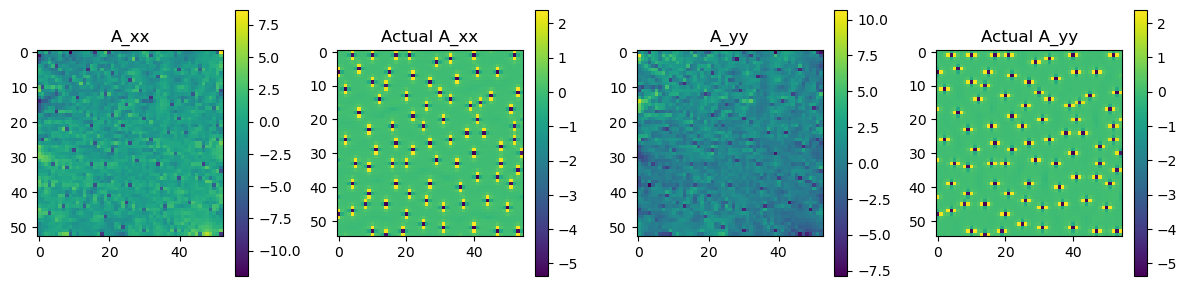

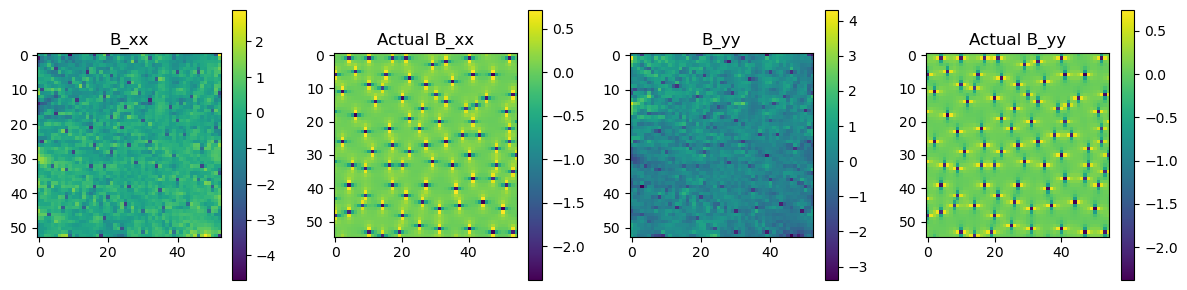

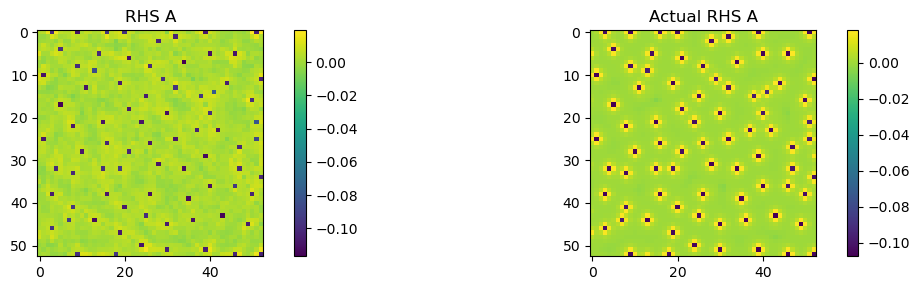

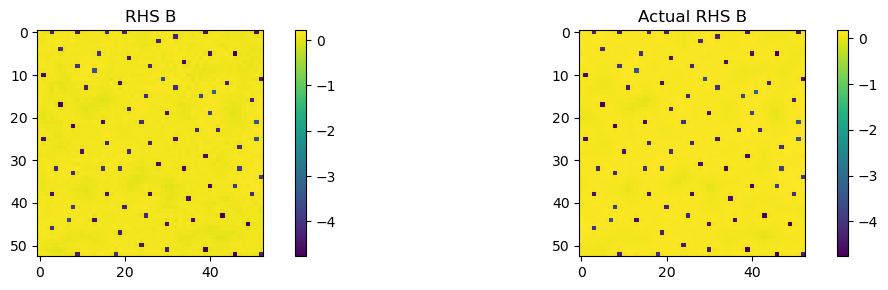

In [38]:
plot_state(pinn1)

In [48]:
def ratio(nom, dnom, n=2):
    return (nom / (dnom + 1e-20)) ** (n)
    
def act(x, km, n=2):
    return 1 / (1 + (km / (x + 1e-20)) ** (n))

def inh(x, km, n=2):
    return 1 / (1 + (x / (km + 1e-20)) ** (n))

A = c[0,:, : , -1]
B = c[1,:, : , -1]
C = c[1,:, : , -1]

# f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
# f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
# f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C

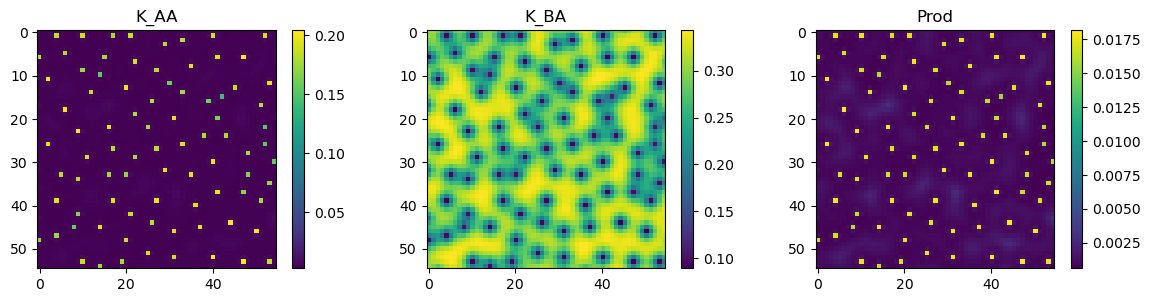

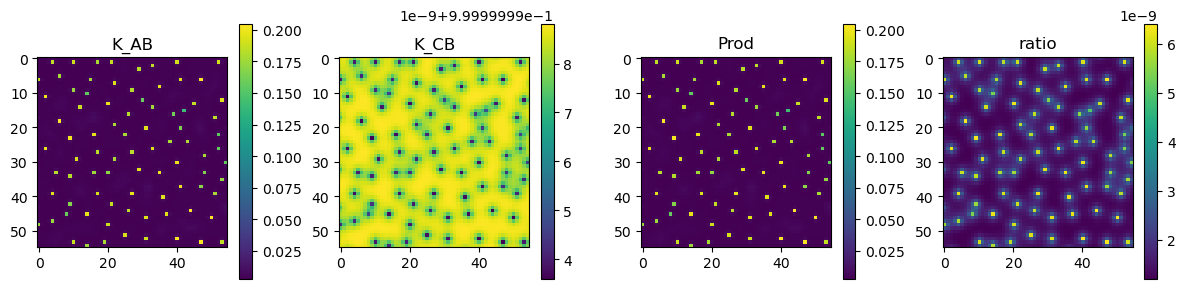

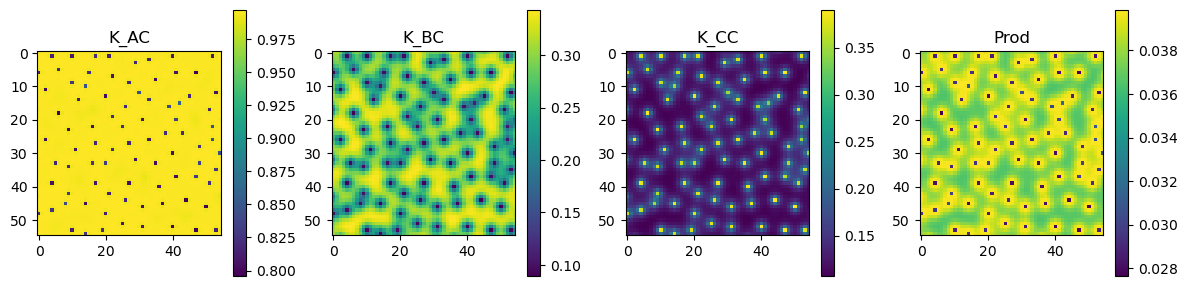

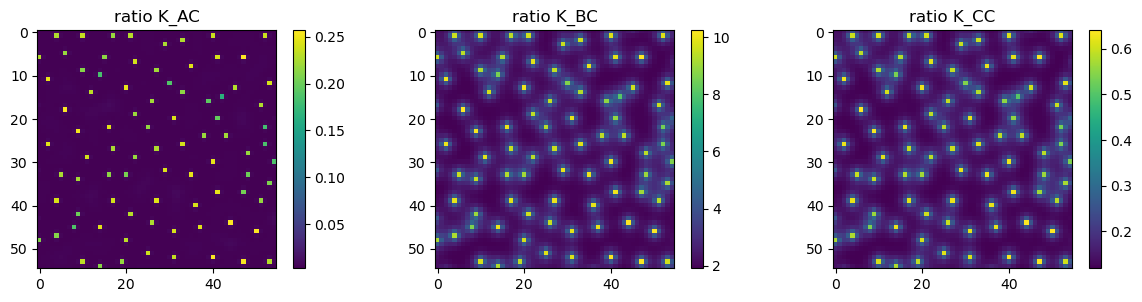

In [50]:
n = params["n"]
plot_n_im([act(A, params["K_AA"], n), inh(B, params["K_BA"], n), 
           act(A, params["K_AA"], n)*inh(B, params["K_BA"], n)],
          ["K_AA", "K_BA", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([act(A, params["K_AB"], n), inh(C, params["K_CB"], n), 
           act(A, params["K_AB"], n)*inh(C, params["K_CB"], n), ratio(C, params["K_CB"], n)],
          ["K_AB", "K_CB", "Prod", "ratio"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([inh(A, params["K_AC"], n), inh(B, params["K_BC"], n), act(C, params["K_CC"], n),
           inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n)],
          ["K_AC", "K_BC", "K_CC", "Prod"],          
              figsize=(12, 3)); plt.tight_layout()

plot_n_im([ratio(A, params["K_AC"], n), ratio(B, params["K_BC"], n), ratio(C, params["K_CC"], n)],
          ["ratio K_AC", "ratio K_BC", "ratio K_CC"],
              figsize=(12, 3)); plt.tight_layout()